# Determine fundus camera model constants from calibration measurements

The focal length of the camera's condenser lens ($f_{cond}$) and the first order calibration term ($a_1$) are determined from measurements with an optical eye model. 

In [7]:
# temporarily add parent directory to sys.path for import of local PAROS version
import sys
sys.path.append('..')

In [8]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

from scipy import optimize
from typing import Callable, NamedTuple

from PAROS import data, eyephantom, fundscale

sp.init_printing(use_unicode=True)

## Load all calibration experiments

In [9]:
lens_file = data.get_lens_data("phantom")

calibration_file = data.get_camera_calibration_data("Topcon", "TRC_50DX")

print(f"Number of calibration experiments: {len(calibration_file)}")

Number of calibration experiments: 9


## Calculate magnifications

Determine the magnification for all experiments and prepare the data for fitting.

In [10]:
def get_ccd_size(
    experiment: pd.Series, measurement: str = "uncorrected_measurement"
) -> float:
    """Get the CCD size for `experiment`.

    The size is obtained from the column `measurement`. Currently, this value
    is returned as is, because the sizes in our DICOM viewer match with the image sizes
    on the CCD.

    Parameters
    ----------
    experiment : pandas.Series
        `Series` with the calibration experiment data.
    measurement : str
        Column from which the CCD size is obtained. Defaults to 'uncorrected_measurement'.
        Values from this column are assumed to be in millimeters.

    Returns
    -------
    float
        Size of the CCD, in meters.
    """
    measured_size = experiment[measurement] * 1e-3

    ccd_size = measured_size

    return ccd_size


def calculate_magnification(
    experiment, measurement="uncorrected_measurement", object_size: float = 10e-3
) -> float:
    """Calculate the magnification of an object by the camera - phantom system.

    The image size is obtained from the column `measurement`.

    Parameters
    ----------
    experiment : pandas.Series
        `Series` with the calibration experiment data.
    measurement : str
        Column from which the image size is obtained. Defaults to 'uncorrected_measurement'.
        Values from this column are assumed to be in millimeters.
    object_size : float
        Size of the object, in millimeters.

    Returns
    -------
    float
        Measured magnification.
    """
    ccd_size = get_ccd_size(experiment, measurement)
    magnification = ccd_size / object_size

    return magnification

In [11]:
def build_system_matrix(
    camera: fundscale.Camera, experiment: pd.Series
) -> tuple[sp.Matrix, eyephantom.EyePhantom]:
    """Build the ray transfer matrix for a camera - phantom system.

    Parameters
    ----------
    camera : fundscale.Camera
        Optical model of the fundus camera.
    experiment : pandas.Series
        Pandas `Series` with data for the calibration experiment.

    Returns
    -------
    focused_system_matrix : sympy.Matrix
        Ray transfer matrix for the focused camera - phantom system.
    eye_phantom : eyephantom.EyePhantom
        Optical model of the eye phantom.
    """
    eye_phantom = eyephantom.EyePhantom(experiment, lens_file=lens_file)

    system_matrix = (
        camera.ray_transfer_matrix
        * eye_phantom.ray_transfer_matrix_to_camera
        * eye_phantom.ray_transfer_matrix
    )

    # Solve for a focused system (B = 0)
    focus_lens_curvature = list(sp.solve(system_matrix[0, 1], camera.R_foc))[0]

    focused_system_matrix = system_matrix.evalf(
        subs=({camera.R_foc: focus_lens_curvature})
    )

    return focused_system_matrix, eye_phantom


class PhantomData(NamedTuple):
    """Eye phantom and metadata."""

    experiment_number: int
    optics_function: Callable
    measured_magnification: float
    focused_system_matrix: sp.Matrix
    eye_phantom: eyephantom.EyePhantom


def make_eye_phantoms(
    experiment_file: pd.DataFrame,
    camera: fundscale.Camera,
    measurement: str = "uncorrected_measurement",
) -> list[PhantomData]:
    """Create `PhantomData` objects for all experiments in `experiment_file`.

    The column in `experiment_file` containing the measured image sizes is
    specified by `measurement`.

    Parameters
    ----------
    experiment_file : pandas.DataFrame
        DataFrame with calibration experiments.
    camera : fundscale.Camera
        Optical model of the fundus camera.
    measurement : str
        Column containing the measured sizes, defaults to 'uncorrrected_measurement'.

    Returns
    -------
    list[PhantomData]
        List of `PhantomData` objects, containing the experiment number, function
        for the system magnification, measured magnification, ray transfer matrix for the
        focused system, and optical model of the eye phantom.
    """
    phantoms = []

    for _, experiment in experiment_file.iterrows():
        focused_system_matrix, eye_phantom = build_system_matrix(camera, experiment)
        magnification_equation = focused_system_matrix[0, 0]
        optics_function = sp.lambdify(
            (camera.F_cond, camera.a1), magnification_equation
        )
        measured_magnification = calculate_magnification(experiment, measurement)

        phantoms.append(
            PhantomData(
                experiment.experiment_number,
                optics_function,
                measured_magnification,
                focused_system_matrix,
                eye_phantom,
            )
        )

    return phantoms

In [12]:
camera = fundscale.Camera()
eye_phantoms = make_eye_phantoms(calibration_file, camera)

## perform fitting of F_cond and a1

In [13]:
def calculate_magnification_for_all_phantoms(
    f_cond: float, a1: float, phantoms: list[PhantomData]
) -> list[tuple[float, float]]:
    """Calculate magnifications for all camera - phantom systems.

    Parameters
    ----------
    f_cond : float
        Focal length of the camera condenser lens, in meters.
    a1 : float
        First order correction term for the camera model.
    phantoms : list[PhantomData]
        System specifications for the camera - phantom systems.

    Returns
    -------
    list[tuple[float, float]]
        List of tuples with the calculated magnification and the measured magnification
        for each camera - phantom system.
    """
    magnifications = []

    for _, optics_function, measured_magnification, *_ in phantoms:
        magnification_fit = optics_function(f_cond, a1)
        magnifications.append([magnification_fit, measured_magnification])

    return magnifications


def loss(x: np.ndarray[float], phantoms: list[PhantomData]) -> float:
    """Loss function to optimize a camera model.

    `x` is a vector of the condenser lens focal length (f_cond) and the first order
    correction term `a1`. The mean absolute difference between the real magnification
    and the calculated magnification is calculated for all camera - phantom systems
    in `phantoms`.

    Parameters
    ----------
    x : NDArray[float]
        Array of two elements: `f_cond` and `a1`.
    phantoms : list[PhantomData]
        Data and models for the camera - phantom systems.

    Returns
    -------
    float
        Mean absolute difference between the real magnification and calculated magnification.
    """
    f_cond, a1 = x

    magnifications = np.array(
        calculate_magnification_for_all_phantoms(f_cond, a1, phantoms)
    )
    magnification_error = np.abs(np.abs(magnifications[:, 0]) - magnifications[:, 1])
    total_error = np.sum(magnification_error) / len(magnification_error)

    return total_error


# Fit the values of f_cond and a1 on the calibration measurements
f_cond_init = 0.030
a1_init = -0.01
fit_result = optimize.minimize(
    loss, np.array([f_cond_init, a1_init]), eye_phantoms, method="Nelder-Mead"
)

if not fit_result.success:
    print(f"Fit failed: {fit_result.message}")
else:
    print(
        "Fit result: \n"
        f"  F_cond = {fit_result.x[0]:.3f}\n"
        f"  a1     = {fit_result.x[1]:.3f}\n"
        f"  loss   = {fit_result.fun:.3f}"
    )

Fit result: 
  F_cond = 0.026
  a1     = -0.010
  loss   = 0.003


Text(0, 0.5, 'Model magnification')

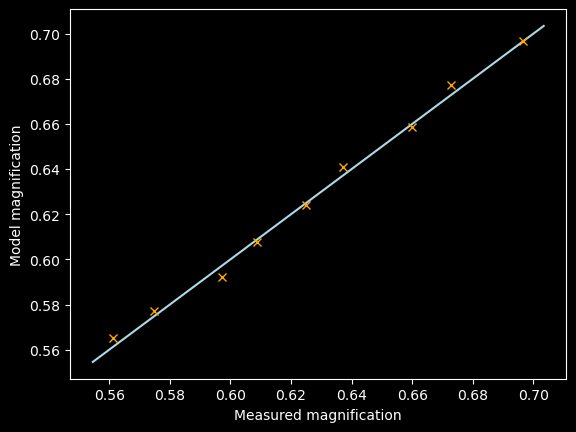

In [14]:
f_cond_fit, a1_fit = fit_result.x

# Calculate phantom data for the fitted parameters
phantom_fits = np.array(
    calculate_magnification_for_all_phantoms(f_cond_fit, a1_fit, eye_phantoms)
)

# Plot phantom fit data
plt.plot(phantom_fits[:, 1], np.abs(phantom_fits[:, 0]), "x", color="orange")

# Plot identity line
plt.plot(xlim := plt.xlim(), xlim, color="lightblue", zorder=0)

plt.xlabel("Measured magnification")
plt.ylabel("Model magnification")